In [19]:
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

ant_data = get_ant_datafiles_info()
data_indoor = pd.DataFrame()
data_outdoor = pd.DataFrame()

for i in range(0,4):
    pre_data = preprocess_antcolony_data(ant_data['file'][i])
    data_indoor = pd.concat([data_indoor,pre_data])

for i in range(5,9):
    pre_data = preprocess_antcolony_data(ant_data['file'][i])
    data_outdoor = pd.concat([data_outdoor,pre_data])

test_indoor = preprocess_antcolony_data(ant_data['file'][4])
test_outdoor = preprocess_antcolony_data(ant_data['file'][9])

data_indoor = data_indoor.dropna()
data_outdoor = data_outdoor.dropna()

test_indoor = test_indoor.dropna()
test_outdoor = test_outdoor.dropna()

data_indoor['location'] = "indoor"
data_outdoor['location'] = "outdoor"

test_indoor["location"] = "indoor"
test_outdoor["location"] = "outdoor"

full_data = pd.concat([data_indoor,data_outdoor])
test_data = pd.concat([test_indoor, test_outdoor])

# shuffle data
full_data = full_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

# sample from full data and test data equally for "indoor" and "outdoor" (balance classes)
max_len_train = min(len(full_data[full_data["location"] == "indoor"]), len(full_data[full_data["location"] == "outdoor"]))
max_len_test = min(len(test_data[test_data["location"] == "indoor"]), len(test_data[test_data["location"] == "outdoor"]))
full_data = pd.concat([full_data[full_data["location"] == "indoor"].sample(n=max_len_train), full_data[full_data["location"] == "outdoor"].sample(n=max_len_train)])
test_data = pd.concat([test_data[test_data["location"] == "indoor"].sample(n=max_len_test), test_data[test_data["location"] == "outdoor"].sample(n=max_len_test)])

# don't use "speed", because the indoor vs outdoor camera fps is different 
X_train = full_data[["cos(angle)"]]
y_train = full_data["location"]

X_test = test_data[["cos(angle)"]]
y_test = test_data["location"]

# lab_enc = preprocessing.LabelEncoder()

# y_train = lab_enc.fit_transform(y_train)
# y_test = lab_enc.fit_transform(y_test)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

Accuracy: 76.25029349612585


Accuracy: 76.27377318619394


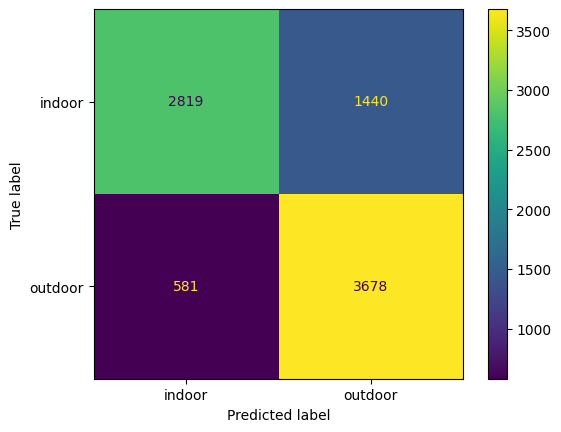

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

cm = confusion_matrix(y_test,y_pred, labels= ["indoor", "outdoor"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["indoor", "outdoor"])
disp.plot()
plt.show()

Accuracy: 0.5451984033810754


<Figure size 1000x1000 with 0 Axes>

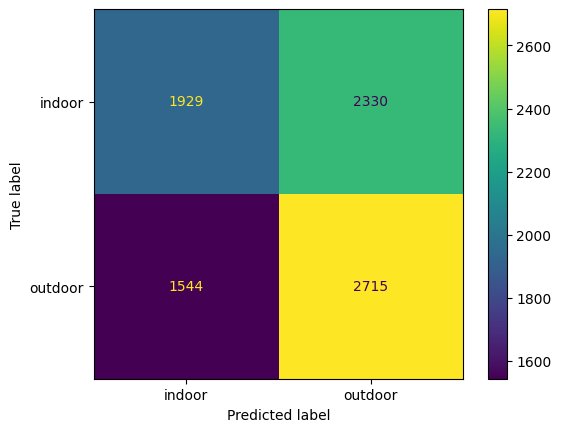

In [34]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(max_iter=1000)
m.fit(X_train,y_train)

y_pred = m.predict(X_test)

plt.figure(figsize=(10,10))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test,y_pred, labels= ["indoor", "outdoor"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["indoor", "outdoor"])
disp.plot()
plt.show()

In [1]:
def system(t, y):
    y1, y2 = y
    dy1dt = -0.1 * y1
    dy2dt = -0.2 * y2
    return [dy1dt, dy2dt]

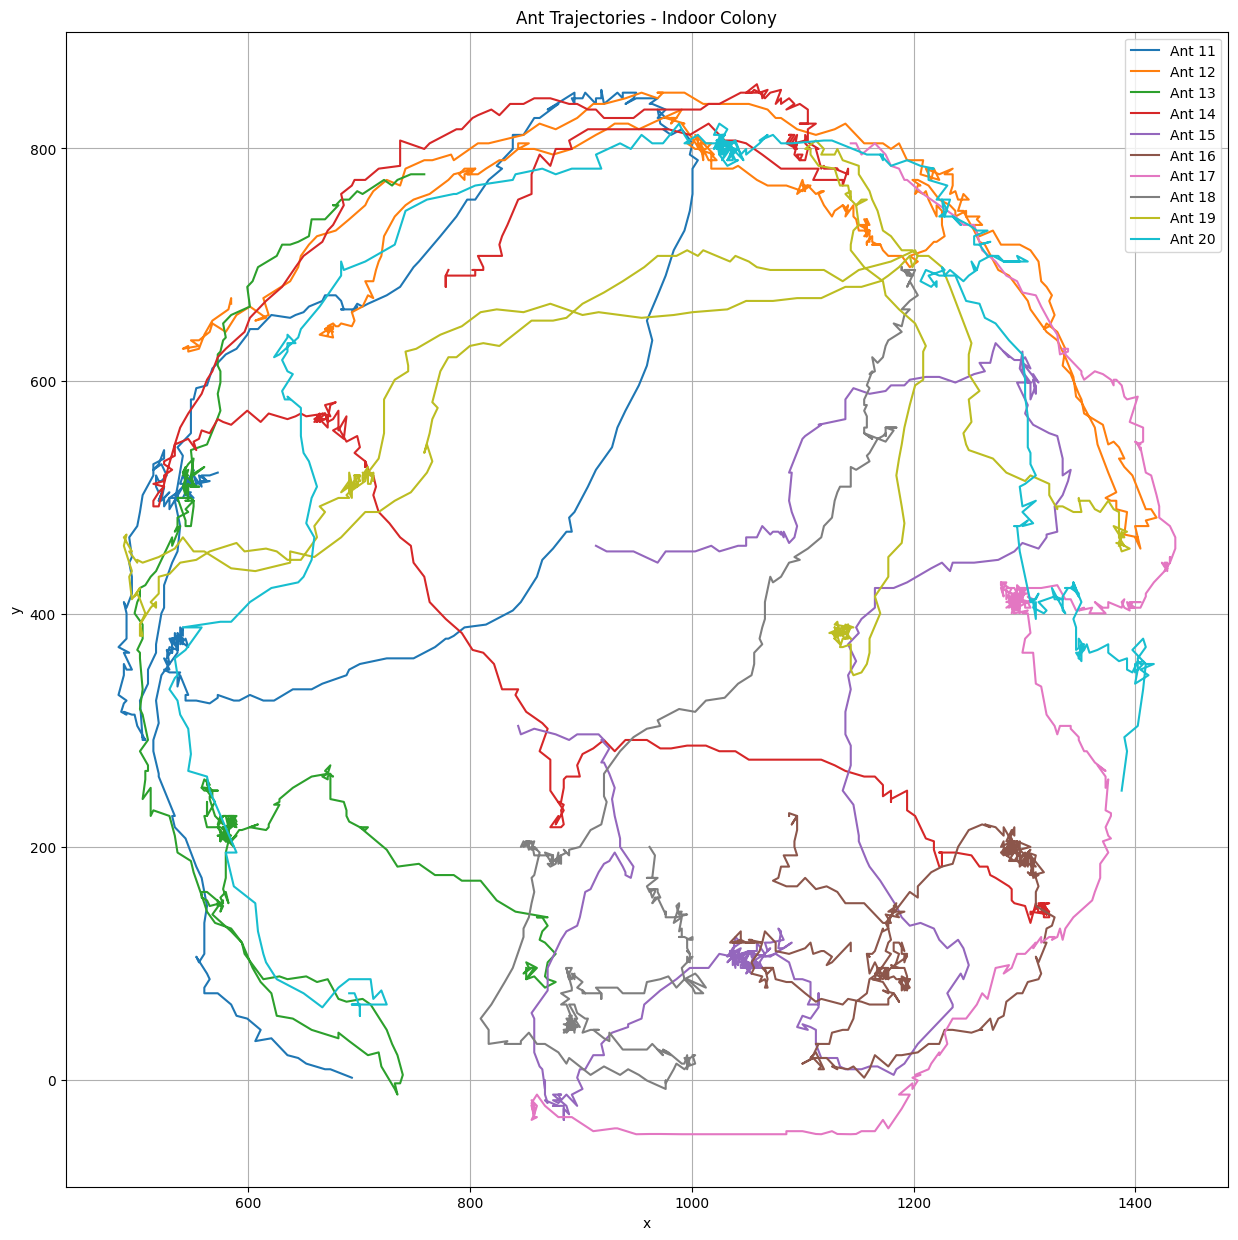

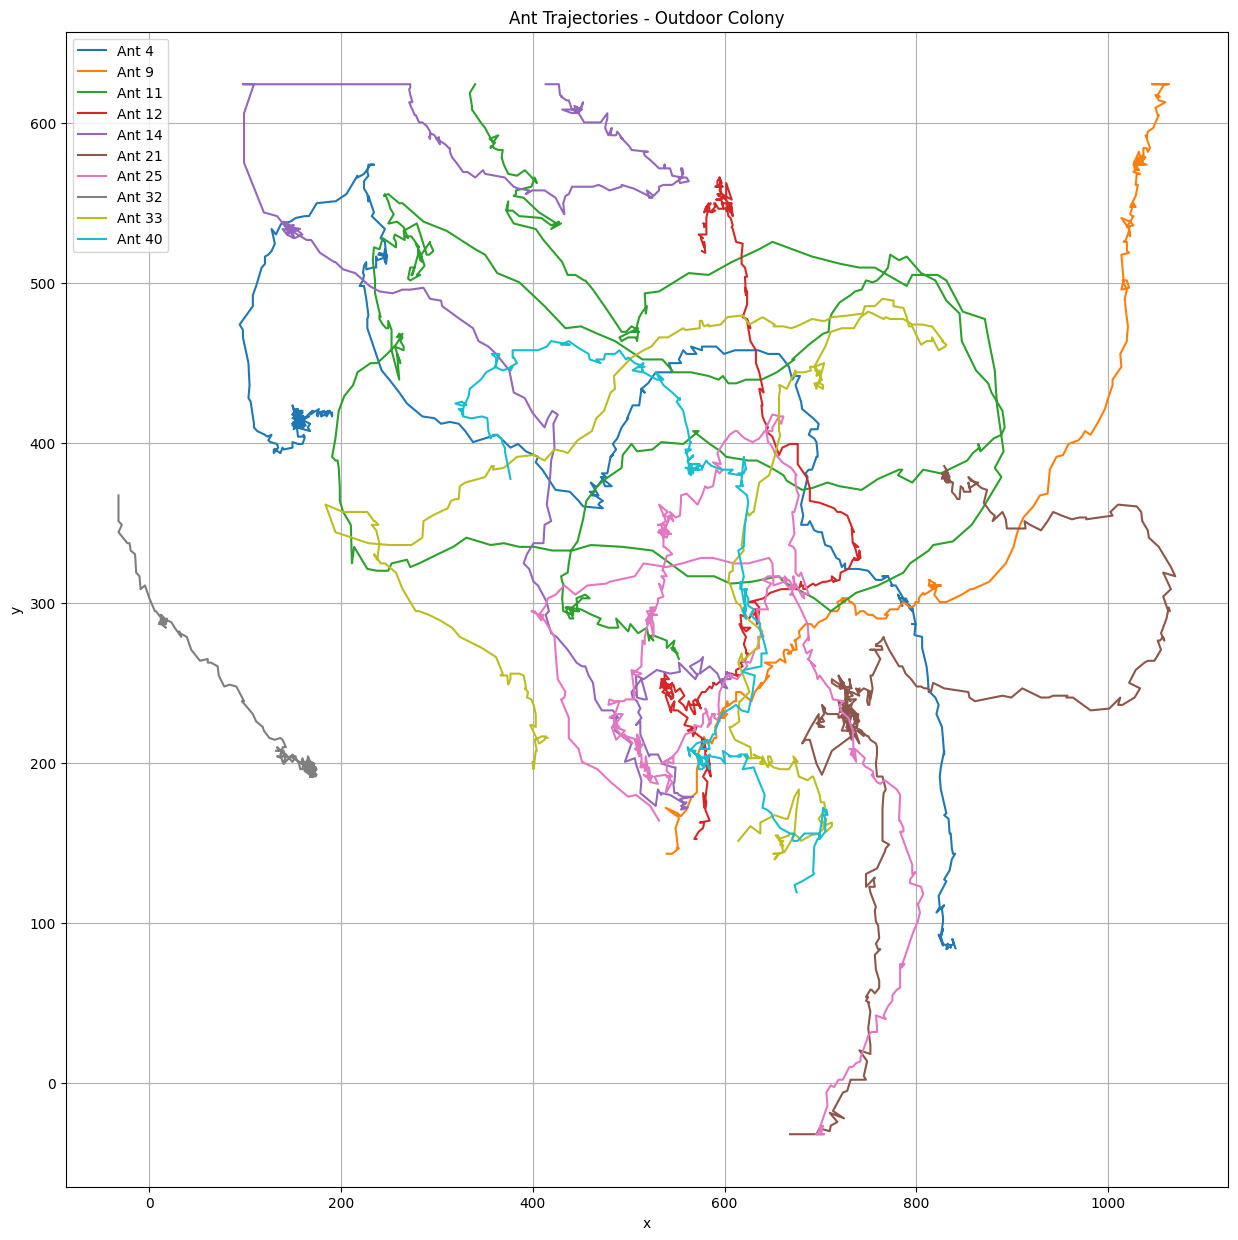

In [20]:
indoor = preprocess_antcolony_data(ant_data['file'][0])
outdoor = preprocess_antcolony_data(ant_data['file'][5])

plt.figure(figsize=(15,15))
for ant_id, ant_d in indoor.groupby('ant_id'):
    plt.plot(ant_d['x'], ant_d['y'], label=f'Ant {ant_id}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Ant Trajectories - Indoor Colony')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,15))
for ant_id, ant_d in outdoor.groupby('ant_id'):
    plt.plot(ant_d['x'], ant_d['y'], label=f'Ant {ant_id}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Ant Trajectories - Outdoor Colony')
plt.legend()
plt.grid(True)
plt.show()   

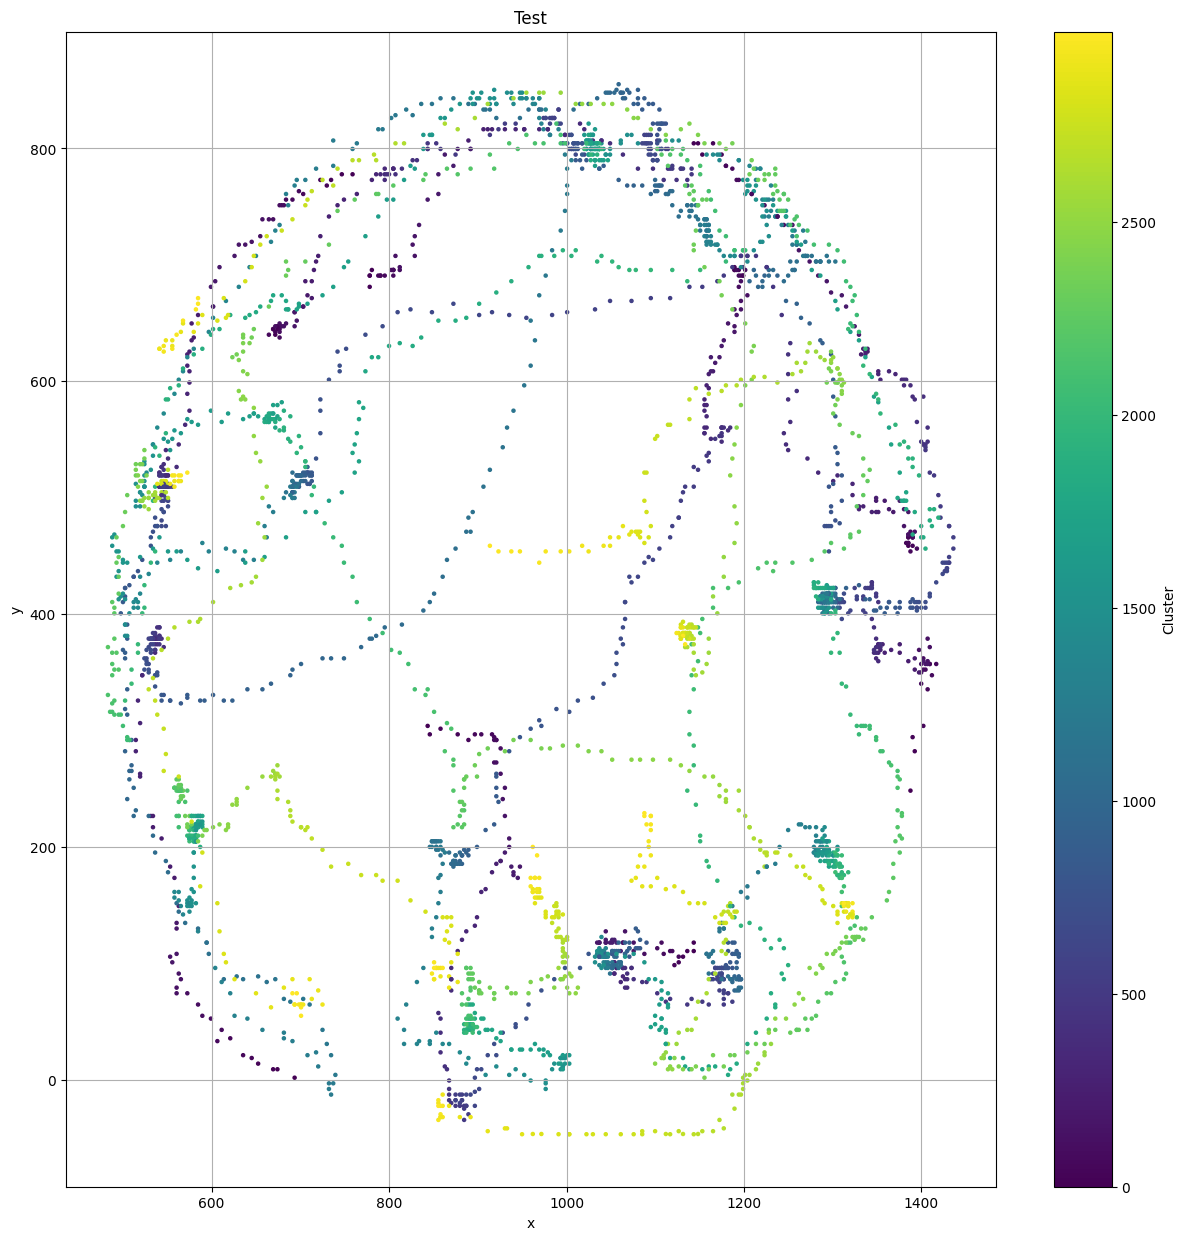

In [4]:
from sklearn.cluster import DBSCAN

X = preprocessed_ant_data[['x','y']]
clust = DBSCAN(eps=0.1, min_samples=1).fit(X)
preprocessed_ant_data['cluster'] =  clust.labels_

plt.figure(figsize=(15,15))
plt.scatter(x,y,c=preprocessed_ant_data['cluster'], cmap = 'viridis', s = 5)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Test")

plt.colorbar(label = "Cluster")
plt.grid(True)
plt.show()

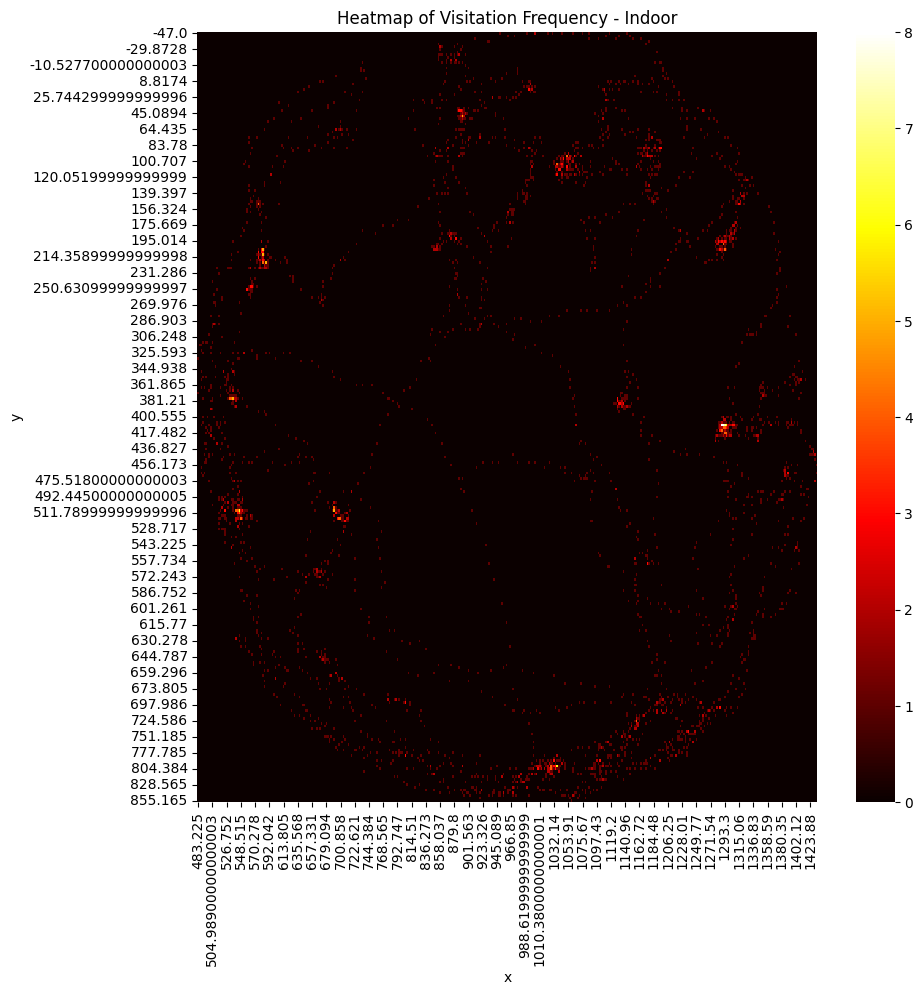

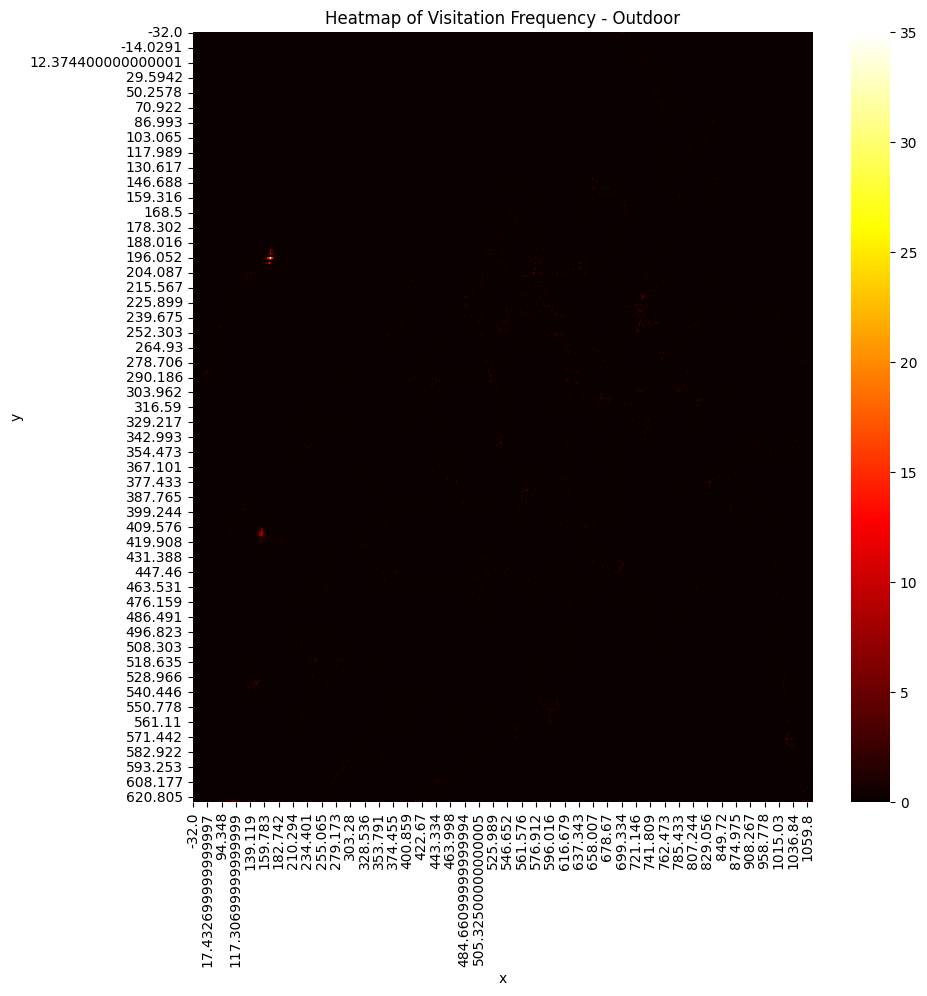

In [24]:
import seaborn as sns

# Create heatmap of visitation frequency
heatmap_in = indoor.groupby(['x', 'y']).size().reset_index(name='count')
heatmap_in = heatmap_in.pivot(index='y', columns='x', values='count').fillna(0)

heatmap_out = outdoor.groupby(['x', 'y']).size().reset_index(name='count')
heatmap_out = heatmap_out.pivot(index='y', columns='x', values='count').fillna(0)

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_in, cmap='hot')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Visitation Frequency - Indoor')
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_out, cmap='hot')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Visitation Frequency - Outdoor')
plt.show()

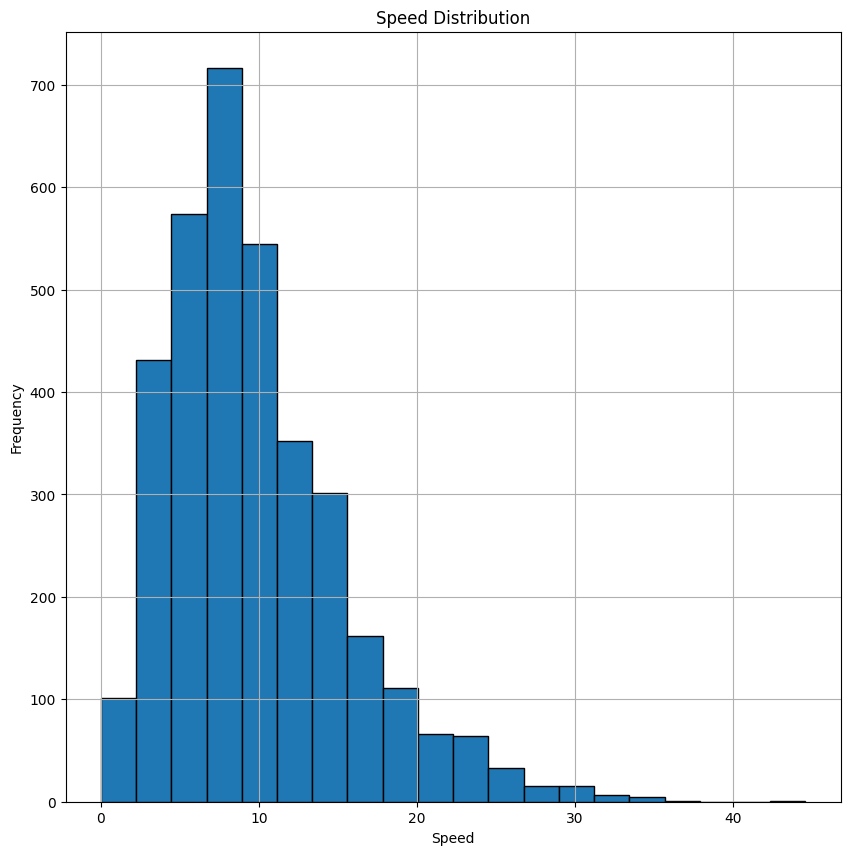

In [6]:
plt.figure(figsize=(10,10))

plt.hist(preprocessed_ant_data['speed'], bins=20, edgecolor = 'black')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.title("Speed Distribution")
plt.grid(True)

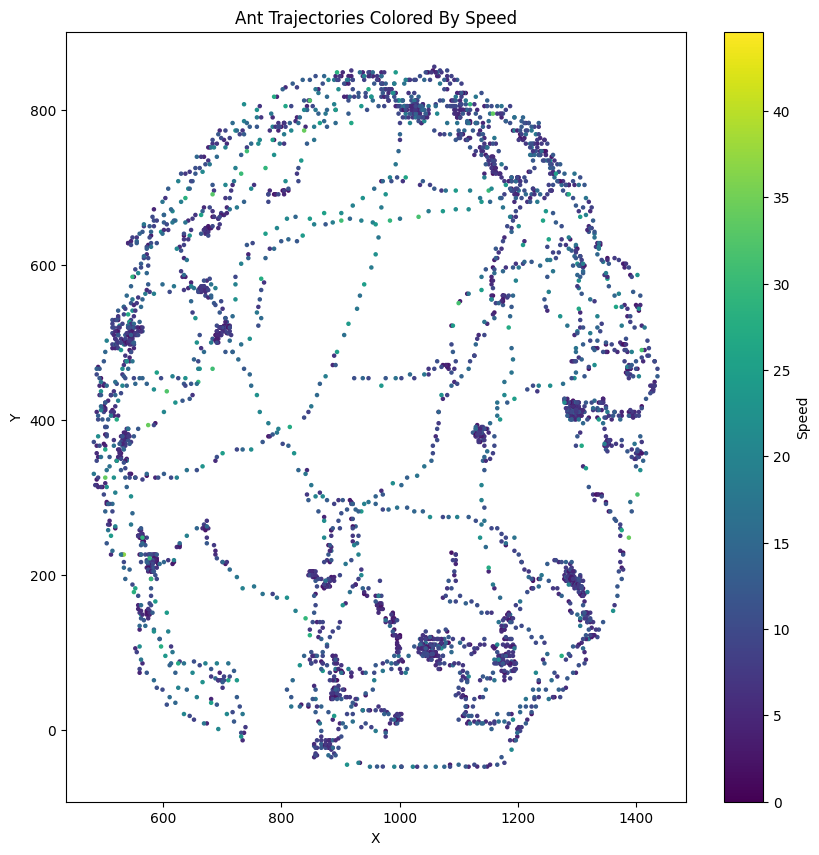

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(x,y,c=preprocessed_ant_data['speed'], cmap='viridis', s =5)
plt.colorbar(label="Speed")
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Ant Trajectories Colored By Speed")
plt.show()

c:\Users\Daniël\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


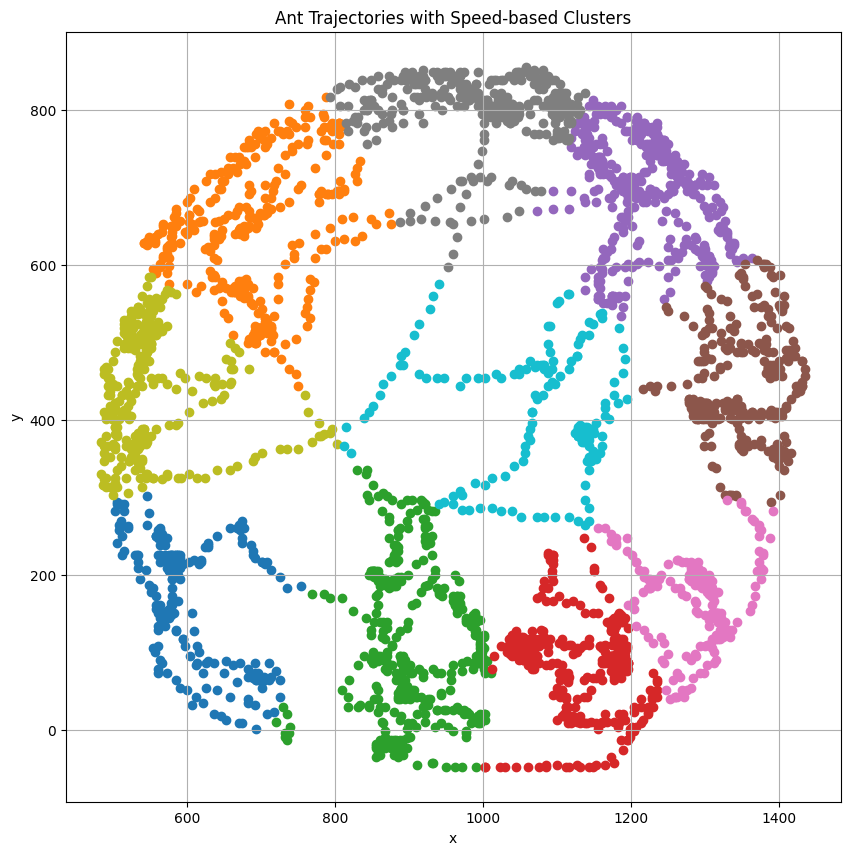

In [8]:
from sklearn.cluster import KMeans

X = preprocessed_ant_data[['x','y','speed']].fillna(0)

kmeans = KMeans(n_clusters=10, random_state=42)
preprocessed_ant_data['cluster_speed'] = kmeans.fit_predict(X)

plt.figure(figsize=(10,10))
for cluster in preprocessed_ant_data['cluster_speed'].unique():
    cluster_data = preprocessed_ant_data[preprocessed_ant_data['cluster_speed'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label = f"Cluster {cluster}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Ant Trajectories with Speed-based Clusters')
plt.grid(True)
plt.show()